In [34]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
EPS = 1e-16

# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':8, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
# multivariate normal initialization variance
sigma_init = 1.0
c_init_order = 5

dirstr = 'V1Circuit_full1'

# create an instance of the V1_circuit system class
fixed_params = {'W_EE':1.0, \
                'W_PE':1.0, \
                'W_SE':1.0, \
                'W_VE':1.0, \
                'h_FFE':0.0, \
                'h_FFP':0.0, \
                'h_LATE':0.0, \
                'h_LATP':0.0, \
                'h_LATS':0.0, \
                'h_LATV':0.0, \
                'tau':1.0, \
                'n':2.0, \
                's_0':30};

behavior_type = 'difference'
c_vals=np.array([0.0])
s_vals=np.array([1.0])
r_vals=np.array([0.0, 1.0])
if (dirstr == 'V1Circuit_full'):
    diff_inds = [0, 1, 2, 3]
    d_mean = np.array([0.3, 0.2, 3.0, 0.0]);
    d_vars = np.array([.001, .001, 0.5, 0.001]);   
elif (dirstr == 'V1Circuit_full1'):
    diff_inds = [0, 1, 2, 3]
    d_mean = np.array([0.15, 0.5, 0.0, 2.0]);
    d_vars = np.array([.01, .01, 0.01, 0.25]);
elif (dirstr == 'V1Circuit_full_EPV_inc_S_same'):
    diff_inds = [0, 1, 2, 3]
    d_mean = np.array([0.25, 0.5, 0.0, 2.5]);
    d_vars = np.array([.01, .01, 0.01, 0.25]);
elif (dirstr == 'V1Circuit_S_same_V_inc'):
    diff_inds = [2, 3]
    d_mean = np.array([0., 2.5]);
    d_vars = np.array([0.01, 0.25]);
else:
    raise NotImplementedError()
behavior = {'type':behavior_type, \
            'diff_inds':diff_inds, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'd_mean':d_mean, \
            'd_var':d_vars}

# set model options
model_opts = {'g_FF':'c', 'g_LAT':'linear', 'g_RUN':'r'}

T = 40
dt = 0.25
init_conds = np.expand_dims(np.array([1.0, 1.1, 1.2, 1.3]), 1)

system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

lr_order = -3

In [3]:

start_rs = 20
num_rs = 1
random_seeds = np.arange(start_rs, num_rs+start_rs)

basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    fnames.append(dsndir + 'opt_info.npz')
    legendstrs.append('rs = %d' % random_seed)
    npzfile = np.load(fname)
    behavior_i = npzfile['behavior'][()]
    cs_i = npzfile['cs']
    k_max = len(cs_i)
    assert(approx_equal(behavior_i['d_mean'], behavior['d_mean'], EPS))
    assert(approx_equal(behavior_i['d_var'], behavior['d_var'], EPS))
    
alpha = 0.05
frac_samps = 0.1
k_max = len(cs_i)
p_values, AL_final_its = assess_constraints(fnames, alpha, frac_samps, \
                                            k_max, system.num_suff_stats);
    

ind  0 behavior checked
0
[24]


0


No handles with labels found to put in legend.


entropy
i
0


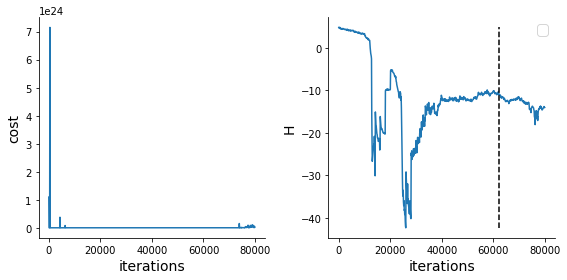

No handles with labels found to put in legend.


constraints
con 0
con 1
con 2
con 3
con 4
con 5
con 6
con 7


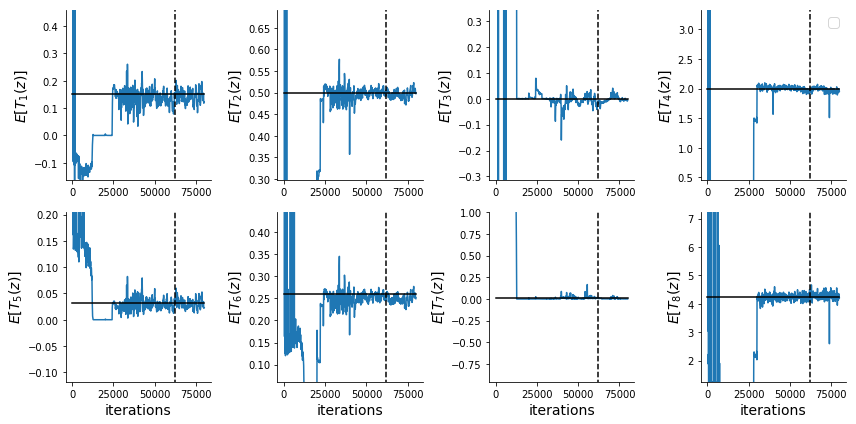

p values
0


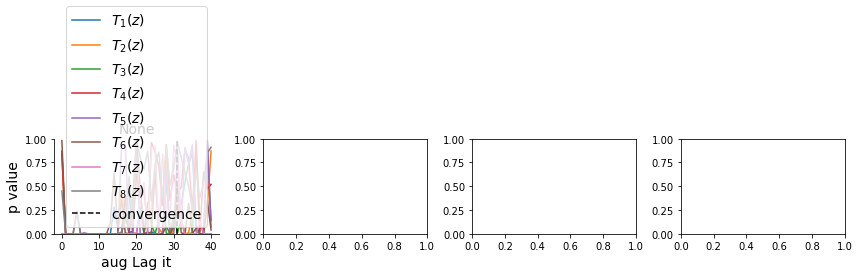

In [4]:
figs, AL_final_its, p_values = plot_opt(fnames, [None], con_method='1', frac_samps=0.15)


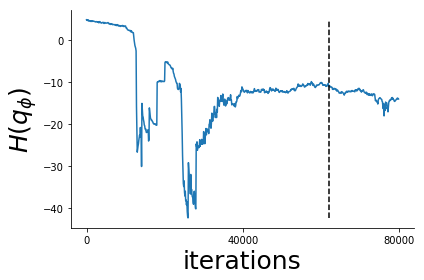

In [5]:
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    it_converge = npzfile['epoch_inds'][AL_final_its[0]]
    fontsize = 25;
    Hs = npzfile['Hs'];
    check_rate = npzfile['check_rate'];
    last_ind = npzfile['it']//check_rate;
    nits = npzfile['costs'].shape[0];
    iterations = np.arange(0, check_rate*nits, check_rate);
    fig = plt.figure();
    ax = fig.add_subplot(111);
    plt.plot(iterations[:last_ind], Hs[:last_ind]);
    plt.plot([it_converge, it_converge], [np.min(Hs), np.max(Hs)], 'k--');
    ax.set_xlabel('iterations', fontsize=fontsize);
    ax.set_ylabel(r'$H(q_\phi)$', fontsize=fontsize);
    ax.set_xticks([0, 40000, 80000])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig('images/V1_opt_H_EPV_inc_S_same.png')
    plt.show();

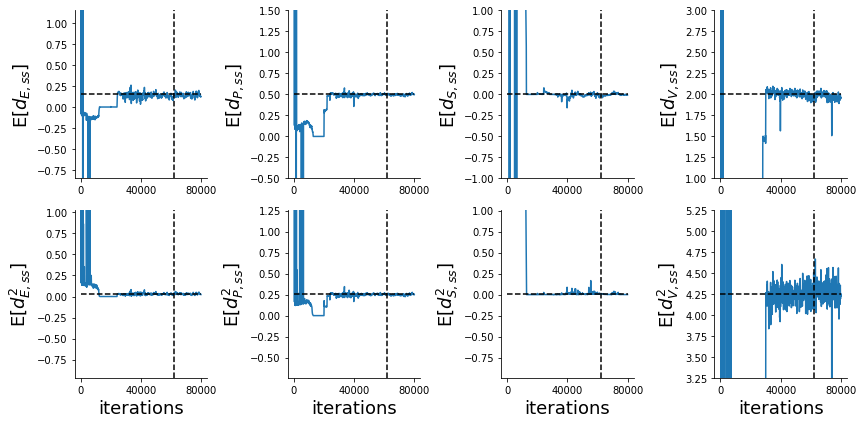

In [7]:
fontsize = 18
ylims = [-1, 4]
yscale_fac = 5
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    epoch_inds = npzfile['epoch_inds']
    it_converge = epoch_inds[AL_final_its[0]]
    mean_T_xs = npzfile['mean_T_xs'];
    mu = npzfile['mu']
    T_xs = npzfile['T_xs'];
    n_suff_stats = mean_T_xs.shape[1];
    n_cols = 4;
    n_rows = int(np.ceil(n_suff_stats/n_cols));
    figsize = (n_cols*3, n_rows*3);
    fig2 = plt.figure(figsize=figsize);
    for i in range(n_suff_stats):
        ymin = mu[i]-1
        ymax = mu[i]+1
        ax = plt.subplot(n_rows,n_cols,i+1);
        ax.plot(iterations[:last_ind], mean_T_xs[:last_ind,i]);
        ax.plot([it_converge, it_converge], [ymin, ymax], 'k--')
        ax.plot([iterations[0], iterations[last_ind]], [mu[i], mu[i]], 'k--');
        ax.set_ylabel(r'E[%s]' % system.T_x_labels[i], fontsize=fontsize);
        if (i > n_suff_stats - n_cols - 1):
            ax.set_xlabel('iterations', fontsize=fontsize);
        ax.set_xticks([0, 40000, 80000])
        ax.set_ylim([ymin, ymax])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.savefig('images/V1_opt_con_EPV_inc_S_same.png')
    plt.show();

10.756226486711203 2.3836003498600546


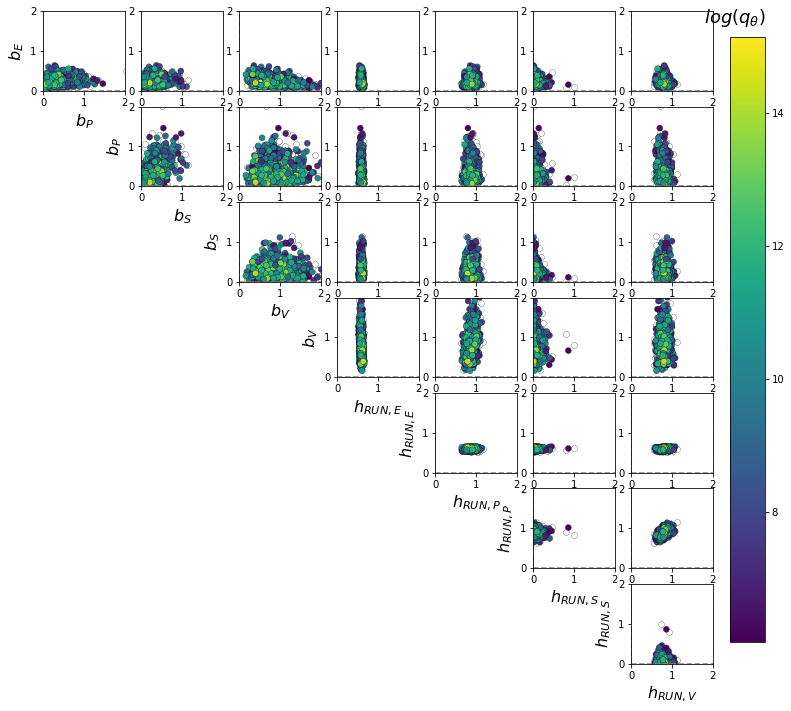

[<Figure size 864x864 with 50 Axes>]

In [8]:
pfname = 'images/V1_Zs_EPV_inc_S_same_logpz.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
              xlims=[0,2], ylims=[0,2], \
              fontsize=16, ellipses=False, tri=True, pfname=pfname)


running simulations to figure out what steady states are.
-0.5865 0.6839354867237113


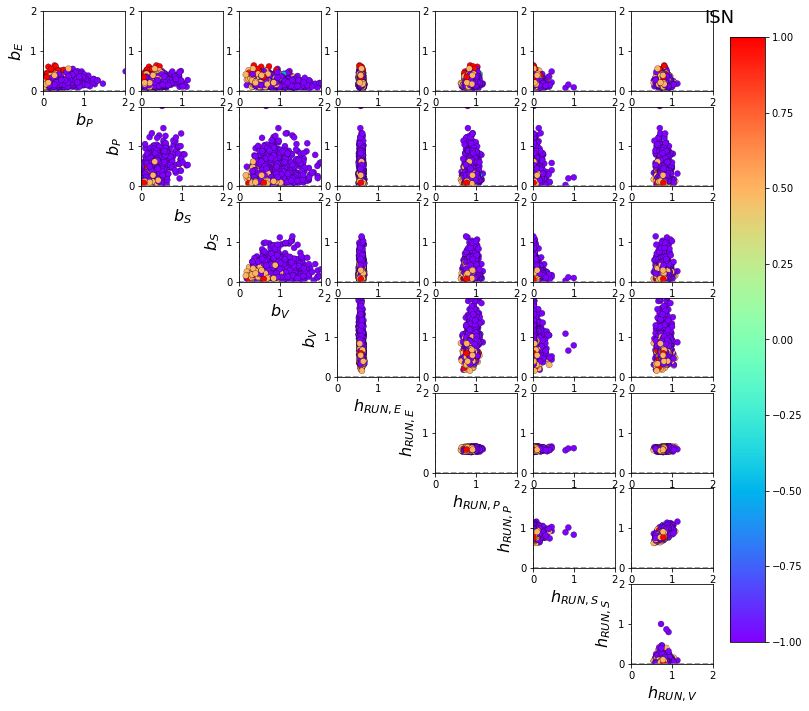

[<Figure size 864x864 with 50 Axes>]

In [9]:
pfname = 'images/V1_Zs_EPV_inc_S_same_ISN.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='ISN', legendstrs=[], AL_final_its=AL_final_its, \
              xlims=[0,2], ylims=[0,2], \
              fontsize=16, ellipses=False, tri=True, \
              outlier_stds=4, pfname=pfname)


0.1416133518032239 0.11474271245177477


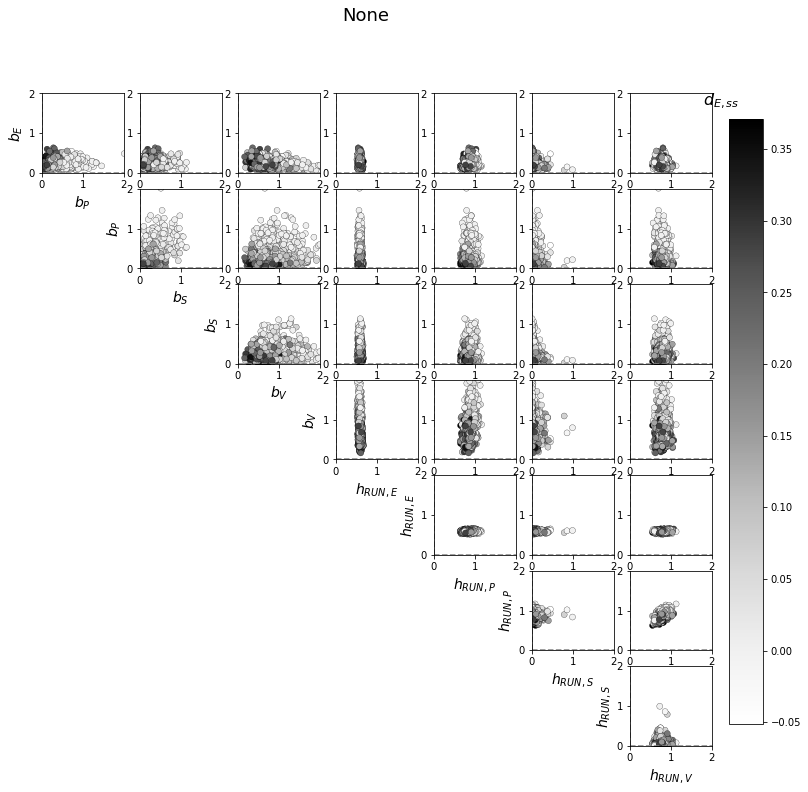

0.5036662230294433 0.058422364594955416


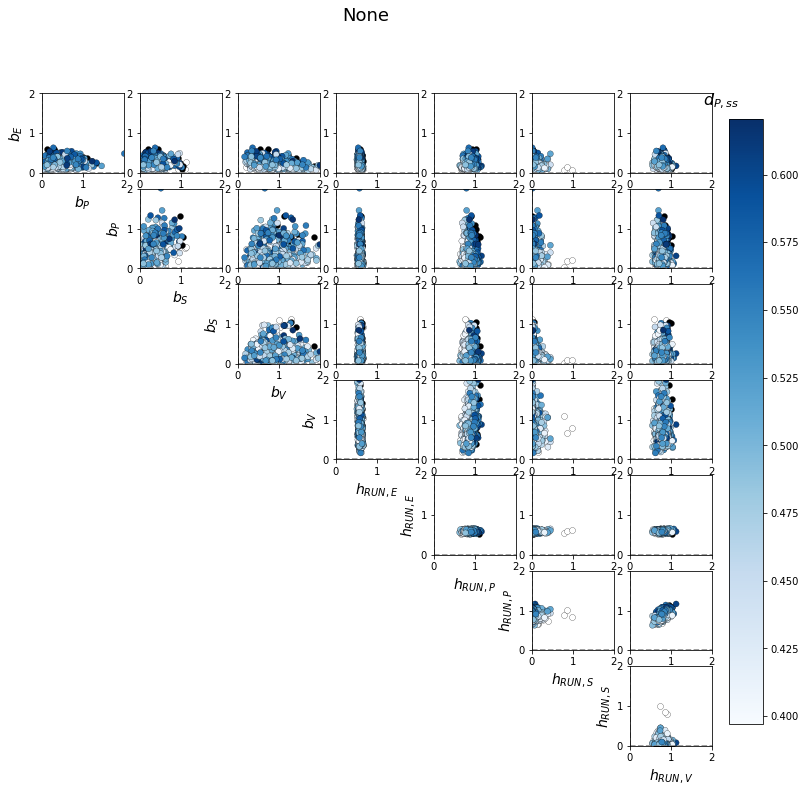

-0.01785069079072376 0.09509692350794123


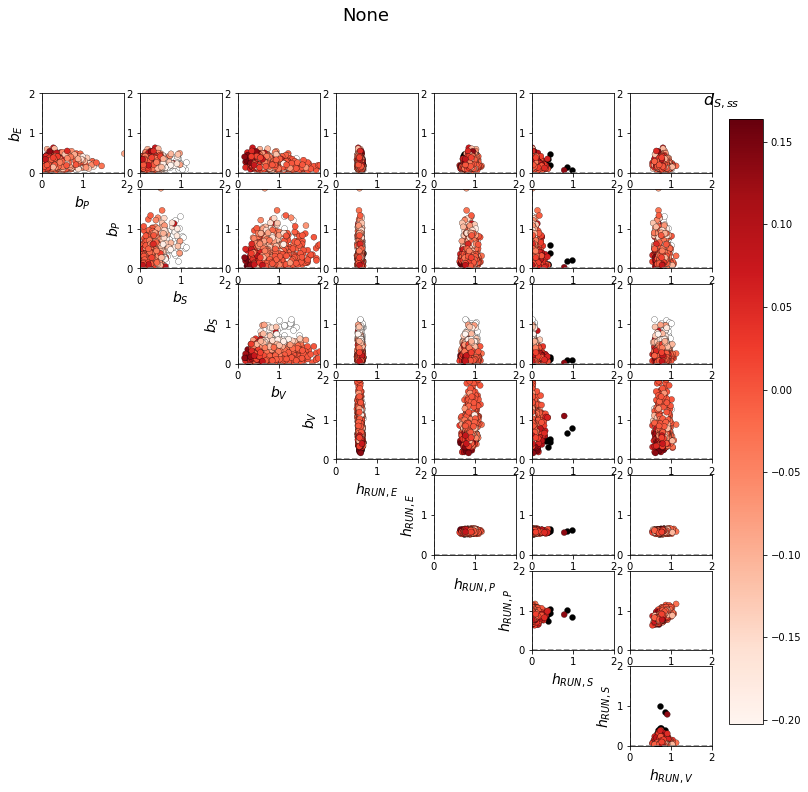

1.971053738326137 0.6013270818707548


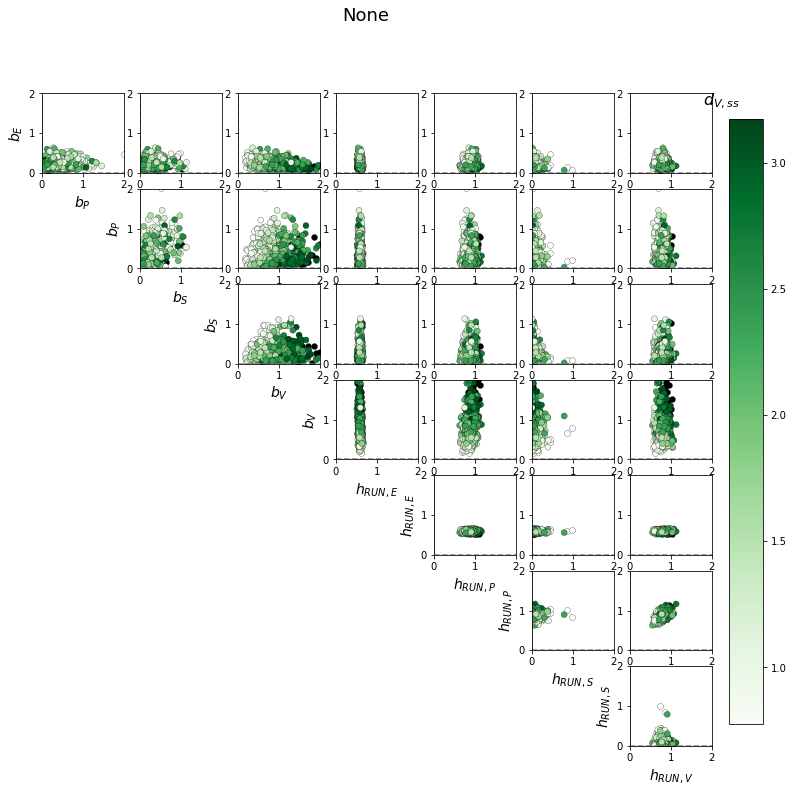

In [10]:


cmaps = [plt.cm.get_cmap('Greys'), plt.cm.get_cmap('Blues'), \
         plt.cm.get_cmap('Reds'), plt.cm.get_cmap('Greens')]
cstrs = ['dE', 'dP', 'dS', 'dV']

if (num_rs == 1):
    figs = []
    for color_ind in range(4):
        pfname = 'images/V1_Zs_EPV_inc_S_same_%s.png' % cstrs[color_ind]
        figs_i = dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
                  c_str=cstrs[color_ind], legendstrs=[None], AL_final_its=AL_final_its, \
                  xlims=[0,2], ylims=[0,2], \
                  fontsize=14, ellipses=False, tri=True, pfname=pfname)
        figs.append(figs_i[0])
        
        
pdf = matplotlib.backends.backend_pdf.PdfPages("images/DSN_V1_small_stimuli_Zs.pdf")
for fig in figs: ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()

10.756226486711203 2.3836003498600546


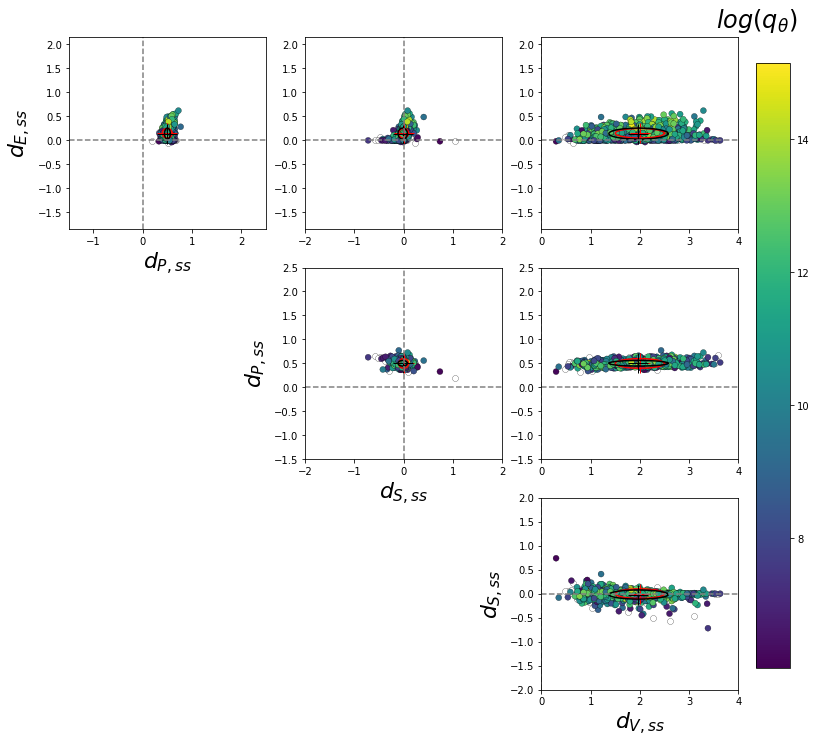

[<Figure size 864x864 with 10 Axes>]

In [12]:
pfname = 'images/V1_T_xs_EPV_inc_S_same_logpz.png'
lims = [-2, 2]
dsn_pairplots(fnames, 'T_xs', system, 4, f_str='identity', \
              c_str='log_q_z', legendstrs=[], AL_final_its=AL_final_its, \
              xlims=lims, ylims=lims, \
              fontsize=22, ellipses=True, tri=True, pfname=pfname)              

running simulations to figure out what steady states are.
-0.5865 0.6839354867237113


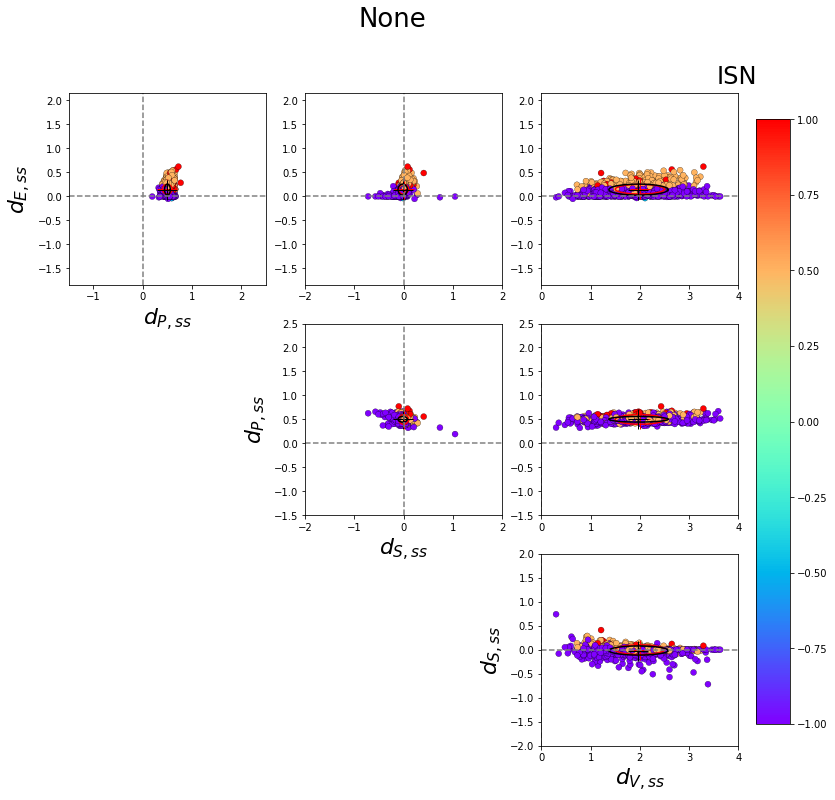

[<Figure size 864x864 with 10 Axes>]

In [14]:
pfname = 'images/V1_T_xs_EPV_inc_S_same_ISN.png'
lims = [-2, 2]
dsn_pairplots(fnames, 'T_xs', system, 4, f_str='identity', \
              c_str='ISN', legendstrs=[None], AL_final_its=AL_final_its, \
              xlims=lims, ylims=lims, \
              fontsize=22, ellipses=True, tri=True, \
              outlier_stds = 4, \
              pfname=pfname)              

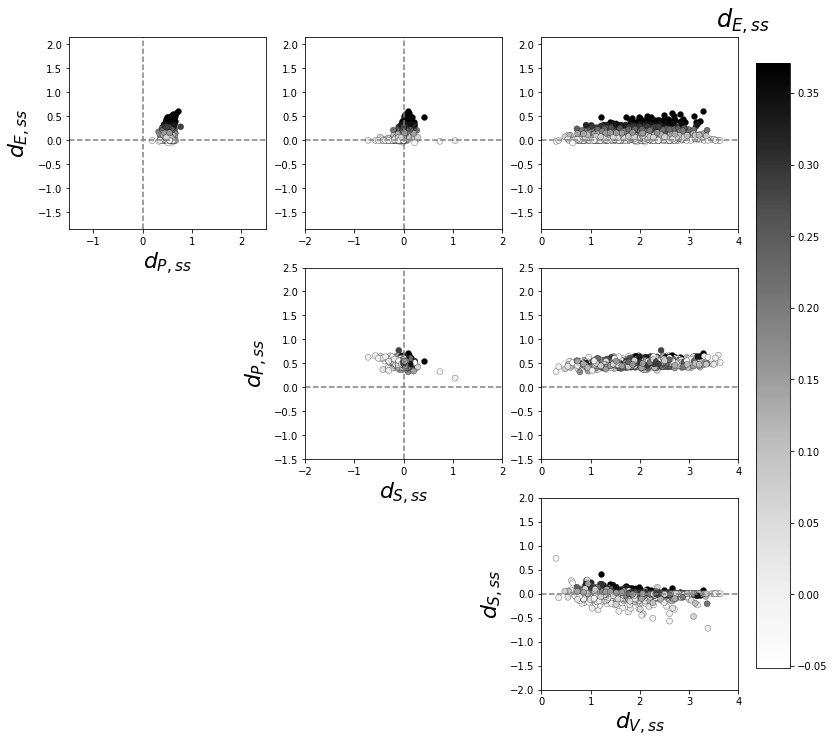

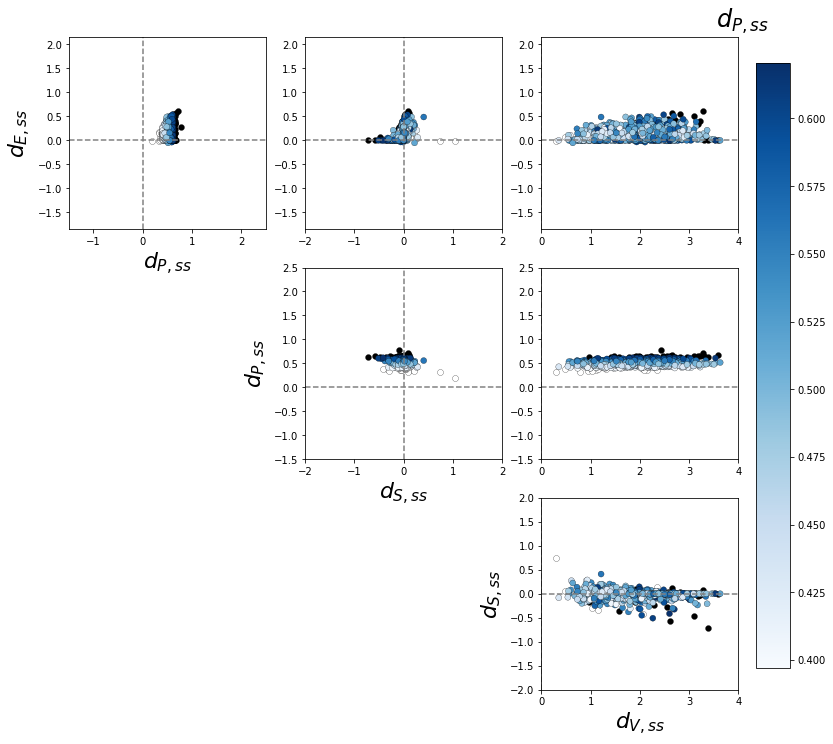

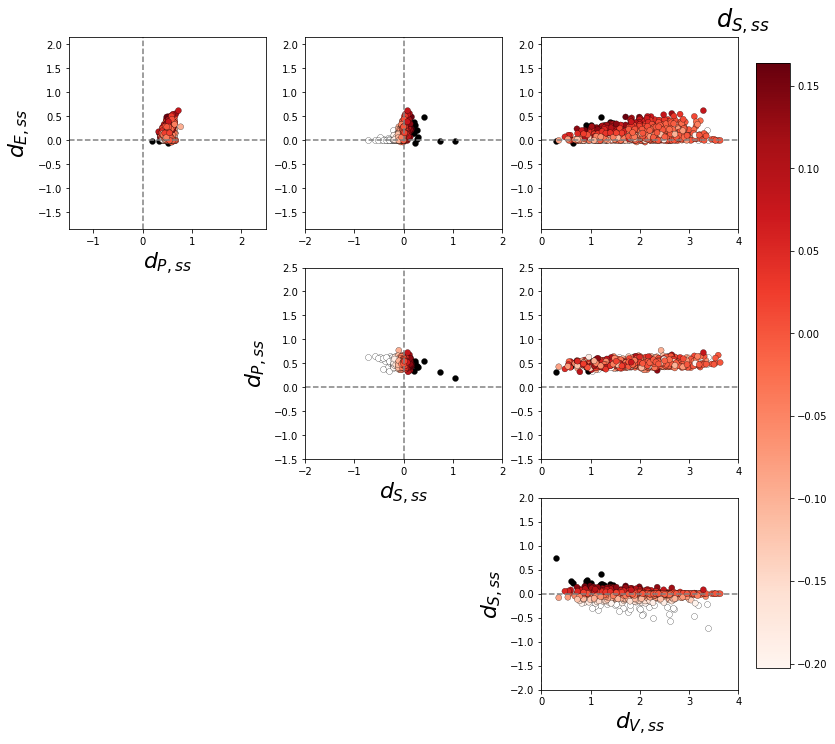

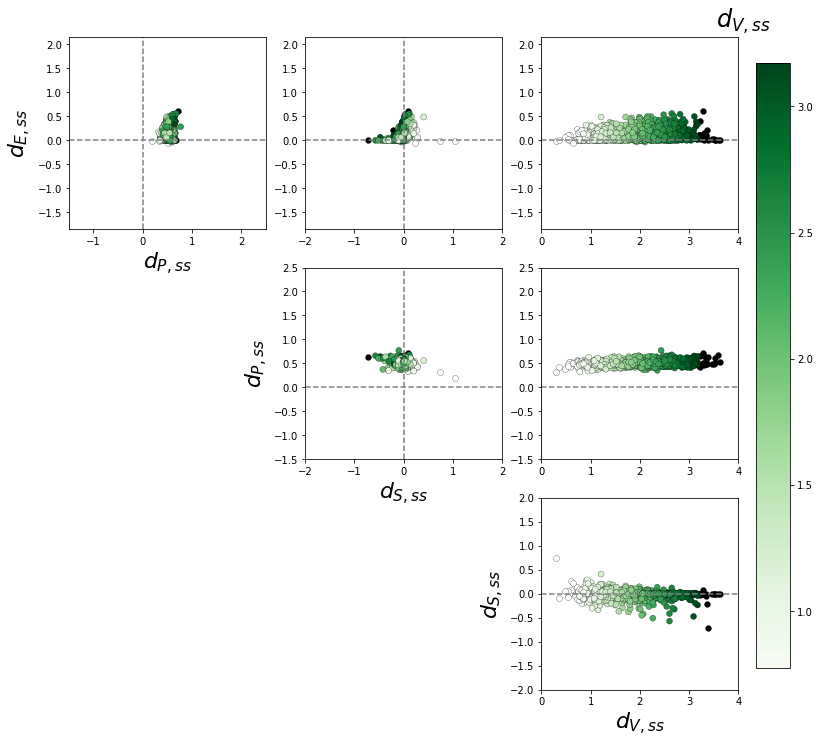

In [17]:
if (num_rs == 1):
    figs = []
    for color_ind in range(4):
        pfname = 'images/V1_T_xs_EPV_inc_S_same_%s.png' % cstrs[color_ind]
        figs_i = dsn_pairplots(fnames, 'T_xs', system, system.D//2, f_str='identity', \
                  c_str=cstrs[color_ind], legendstrs=[], AL_final_its=AL_final_its, \
                  xlims=lims, ylims=lims, \
                  fontsize=22, ellipses=False, tri=True, pfname=pfname)
        figs.append(figs_i[0])
        
pdf = matplotlib.backends.backend_pdf.PdfPages("images/DSN_V1_small_stimuli_T_xs.pdf")
for fig in figs: ## will open an empty extra figure :(
    pdf.savefig(fig)
pdf.close()


In [18]:
behavior_type = 'difference'
diff_inds = [0, 1, 2, 3]
c_vals=np.array([0.0])
s_vals=np.array([1.0])
r_vals=np.array([0.0, 1.0])
d_mean = np.array([0.0, 0.0, 1.0, 0.0]);
d_vars = np.array([0.1, 0.1, 0.1, 0.1]);
behavior = {'type':behavior_type, \
            'diff_inds':diff_inds, \
            'c_vals':c_vals, \
            's_vals':s_vals, \
            'r_vals':r_vals, \
            'd_mean':d_mean, \
            'd_var':d_vars}

full_system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)
Z = tf.placeholder(dtype=tf.float64, shape=(None, None, system.D));
T_x = full_system.compute_suff_stats(Z)

20 1


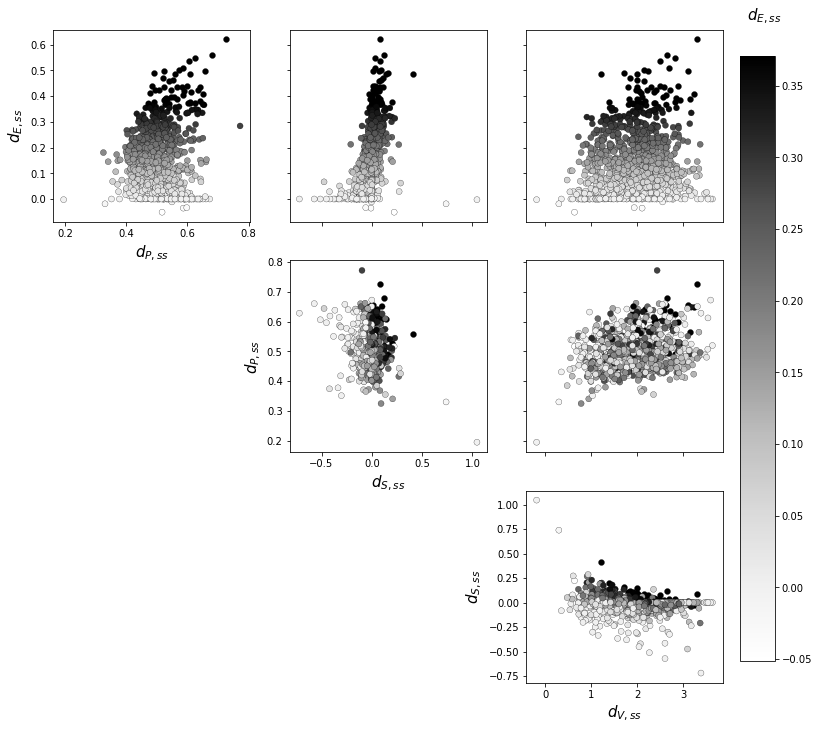

In [22]:
print(start_rs, num_rs)
ind = 0
for rs in range(start_rs, num_rs+start_rs):
    AL_final_it = AL_final_its[ind]
    if (AL_final_it is None):
        continue
    npzfile = np.load(fnames[ind])
    _Zs = npzfile['Zs']
    log_p_zs = npzfile['log_q_zs']
    with tf.Session() as sess:
        _T_x = sess.run(T_x, {Z:np.expand_dims(_Zs[AL_final_it], 0)})

    system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

    lims = None
    fig = pairplot(_T_x[0], range(4), full_system.T_x_labels, origin=False, \
                           c=_T_x[0,:,0], c_label=full_system.T_x_labels[0], cmap=plt.cm.get_cmap('Greys'), \
                           xlims=lims, ylims=lims, fontsize=15, \
                           figsize=(12,12), pfname='images/temp.png')
    ind += 1


31
rs = 20


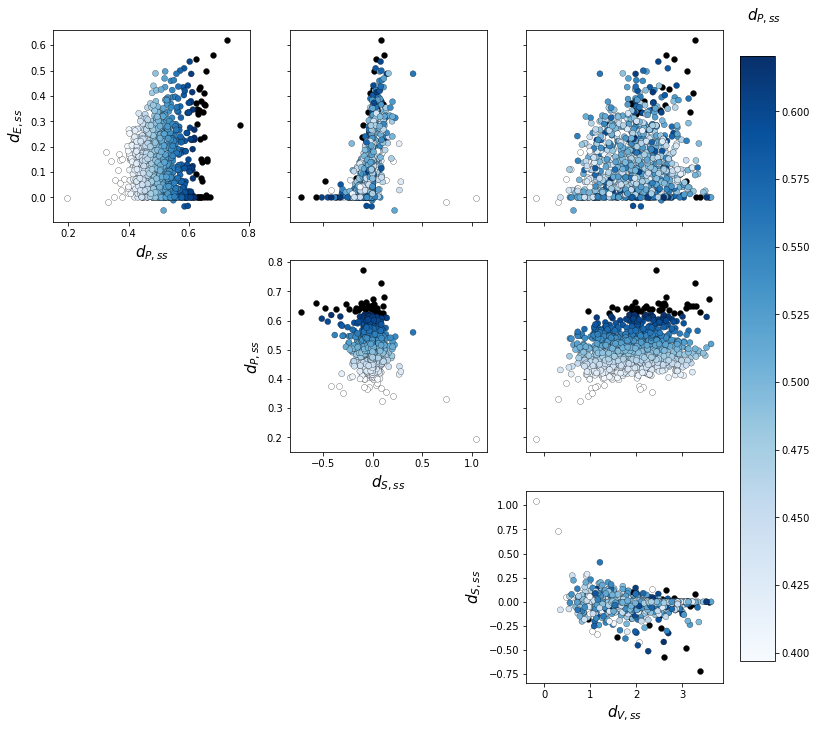

In [24]:
ind = 0
for rs in range(start_rs, num_rs+start_rs):
    AL_final_it = AL_final_its[ind]
    if (AL_final_it is None):
        continue
    npzfile = np.load(fnames[ind])
    _Zs = npzfile['Zs']
    log_p_zs = npzfile['log_q_zs']
    print(AL_final_it)
    with tf.Session() as sess:
        _T_x = sess.run(T_x, {Z:np.expand_dims(_Zs[AL_final_it], 0)})

    system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

    lims = None
    print('rs = %d'% rs)
    fig = pairplot(_T_x[0], range(4), full_system.T_x_labels, origin=False, \
                   c=_T_x[0,:,1], c_label=full_system.T_x_labels[1], cmap=plt.cm.get_cmap('Blues'), \
                   xlims=lims, ylims=lims, fontsize=15, \
                   figsize=(12,12), pfname='images/temp.png')
    ind += 1

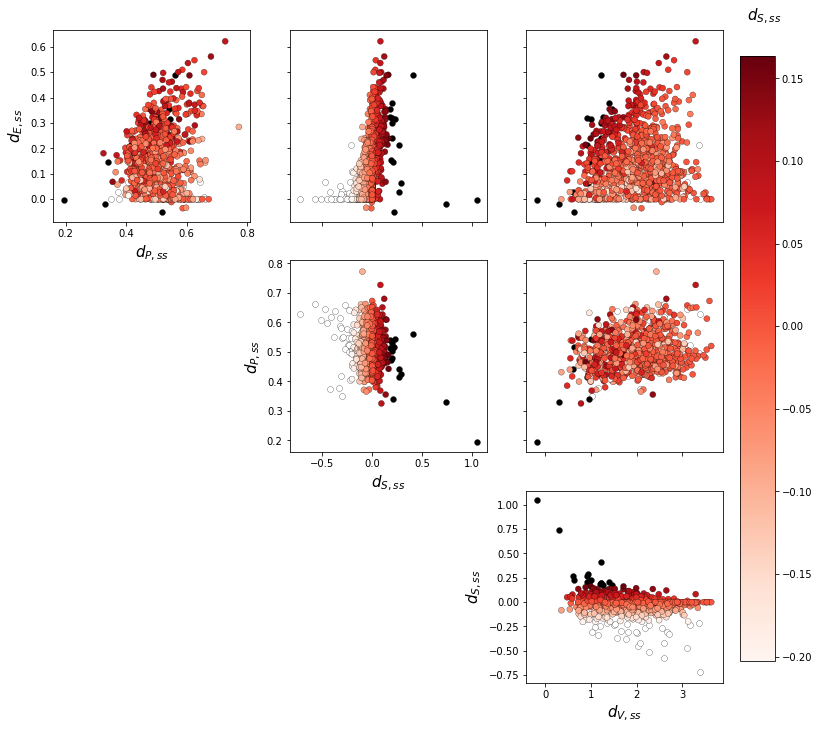

In [25]:
ind = 0
for rs in range(start_rs, num_rs+start_rs):
    AL_final_it = AL_final_its[ind]
    if (AL_final_it is None):
        continue
    npzfile = np.load(fnames[ind])
    _Zs = npzfile['Zs']
    log_p_zs = npzfile['log_q_zs']
    with tf.Session() as sess:
        _T_x = sess.run(T_x, {Z:np.expand_dims(_Zs[AL_final_it], 0)})

    system = V1Circuit(fixed_params, behavior, model_opts, T, dt, init_conds)

    lims = None
    fig = pairplot(_T_x[0], range(4), full_system.T_x_labels, origin=False, \
                   c=_T_x[0,:,2], c_label=full_system.T_x_labels[2], cmap=plt.cm.get_cmap('Reds'), \
                   xlims=lims, ylims=lims, fontsize=15, \
                   figsize=(12,12), pfname='images/temp.png')
    ind += 1

In [28]:
p_values, AL_final_its = assess_constraints(fnames, alpha, frac_samps, \
                                            k_max, system.num_suff_stats);
AL_final_it = AL_final_its[0]
fname = fnames[0]
npzfile = np.load(fname)
Zs = npzfile['Zs'][AL_final_it]
T_xs = npzfile['T_xs'][AL_final_it]

0


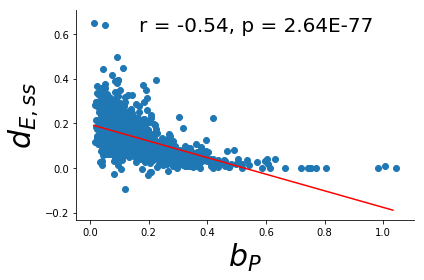

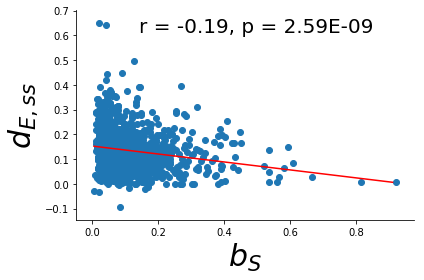

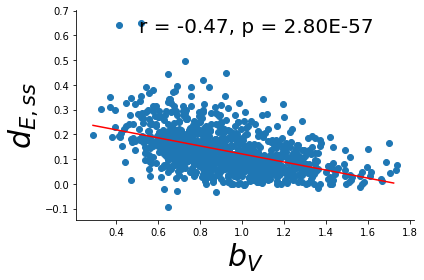

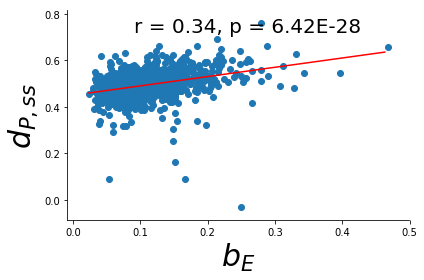

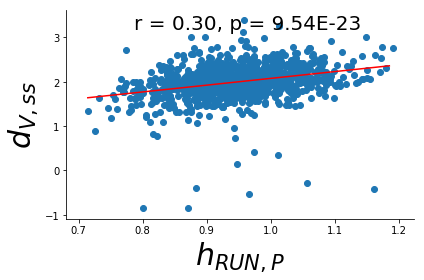

In [36]:
fontsize = 30
    
z_inds = [1, 2, 3, 0, 5]
T_inds = [0, 0, 0, 1, 3]
num_inds = len(z_inds)
for i in range(num_inds):
    z_ind = z_inds[i]
    T_ind = T_inds[i]
    lin_reg_plot(Zs[:,z_ind], T_xs[:,T_ind], system.z_labels[z_ind], system.T_x_labels[T_ind], \
                 pfname='images/corr%d' % (i+1), fontsize=fontsize)

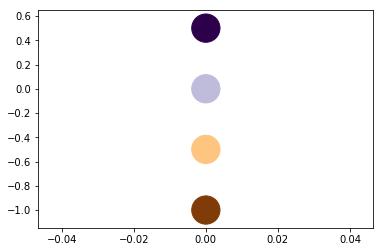

In [37]:
cmap = plt.cm.get_cmap('PuOr')
x = [0.0]*4
y = [-1, -0.5, 0.0, 0.5]
plt.figure()
plt.scatter(x, y, c=y, cmap=cmap, s=800)
plt.show()